# Online Retail Sales Trend Forecasting & RFM-Based Customer Clustering - Ahmed El Abed [60301047]



## Project Introduction

**Project Title:** Online Retail Sales Trend Analysis and Forecasting  
**Author:** Ahmed El Abed  
**Student ID:** 60301047  
**Date:** June 2025  
**Source:** [Kaggle – Online Retail II (UCI)](https://www.kaggle.com/datasets/mashlyn/online-retail-ii-uci)

---

**Business Domain: Retail / E-Commerce Analytics:**  
This project focuses on analyzing the time-based sales performance of a UK-based online retail store. The dataset captures detailed transactional information of products sold across multiple countries over two years (2009–2011), making it ideal for time series forecasting and sales trend exploration.

**Problem Definition:**  
The business seeks to improve its understanding of revenue drivers and customer patterns to make better strategic decisions. Specifically, it aims to:
- Analyze when and where revenue surges occur
- Forecast future monthly sales
- Segment customers based on behavioral patterns
- Visualize key metrics for executive reporting

**Objectives:**
- Explore and visualize sales patterns to identify key drivers of revenue trends  
- Analyze monthly revenue and seasonal patterns using time series decomposition  
- Forecast future revenue using ARIMA and SARIMA models to support inventory and marketing planning  
- Evaluate model accuracy using RMSE and interpret forecast performance against actuals  
- Segment customers based on purchasing behavior using RFM (Recency, Frequency, Monetary) analysis  
- Visualize product- and country-level performance to guide regional and category-specific strategies  
- Deliver insights through a professional and interactive Power BI dashboard for business stakeholders

**Dataset Structure:**  
- `InvoiceNo`: Unique invoice code (returns prefixed with "C")  
- `StockCode`: Product identifier  
- `Description`: Product description  
- `Quantity`: Number of units sold  
- `InvoiceDate`: Date and time of transaction  
- `UnitPrice`: Price per unit (GBP)  
- `CustomerID`: Anonymized customer identifier  
- `Country`: Country of customer

## Import Required Libraries & Load Dataset

In [65]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statsmodels.tsa.stattools import adfuller
from mpl_toolkits.mplot3d import Axes3D
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.ticker as ticker
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import IPython.display as disp


warnings.filterwarnings("ignore")
plt.style.use('default')

In [66]:
# Load the Dataset
df = pd.read_csv("online_retail_II.csv")

# Preview first few rows
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [67]:
# Display dataset structure and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [68]:
# Display statistical summary
df.describe()

,Quantity,Price,Customer ID
count,1.067371e+06,1.067371e+06,824364.000000
mean,9.938898e+00,4.649388e+00,15324.638504
std,1.727058e+02,1.235531e+02,1697.464450
min,-8.099500e+04,-5.359436e+04,12346.000000
25%,1.000000e+00,1.250000e+00,13975.000000
50%,3.000000e+00,2.100000e+00,15255.000000
75%,1.000000e+01,4.150000e+00,16797.000000
max,8.099500e+04,3.897000e+04,18287.000000


## Data Cleaning and Preprocessing

In [69]:
# Check for missing values in each column
df.isnull().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

In [70]:
# Drop rows with missing essential fields: Description, Customer ID
df = df.dropna(subset=['Customer ID', 'Description'])

# Check again after dropping
df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [71]:
# Drop zero-price records
print("Zero-price records (before removal):", (df['Price'] == 0).sum())
df = df[df['Price'] > 0]

# Drop refund records
print("Refunded records (before removal):", df['Invoice'].astype(str).str.startswith('C').sum())
df = df[~df['Invoice'].astype(str).str.startswith('C')]

Zero-price records (before removal): 71
Refunded records (before removal): 18744


In [72]:
# Optional QA Check: confirm that refund and zero-price records were removed
print("Refunded records remaining:", df[df['Invoice'].astype(str).str.startswith('C')].shape[0])
print("Zero-price records remaining:", df[df['Price'] == 0].shape[0])

Refunded records remaining: 0
Zero-price records remaining: 0


In [73]:
# Convert 'InvoiceDate' to datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Confirm the conversion
print("InvoiceDate dtype:", df['InvoiceDate'].dtype)

InvoiceDate dtype: datetime64[ns]


In [74]:
# Final confirmation of dataset shape after cleaning
print("Final dataset shape after removing refunds and zero-price items:", df.shape)

# Set InvoiceDate as datetime index and sort
df.set_index('InvoiceDate', inplace=True)
df.sort_index(inplace=True)

# Preview the cleaned dataset
df.head()

Final dataset shape after removing refunds and zero-price items: (805549, 8)


,Invoice,StockCode,Description,Quantity,Price,Customer ID,Country
InvoiceDate,,,,,,,
2009-12-01 07:45:00,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,6.95,13085.0,United Kingdom
2009-12-01 07:45:00,489434,79323P,PINK CHERRY LIGHTS,12,6.75,13085.0,United Kingdom
2009-12-01 07:45:00,489434,79323W,WHITE CHERRY LIGHTS,12,6.75,13085.0,United Kingdom
2009-12-01 07:45:00,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2.10,13085.0,United Kingdom
2009-12-01 07:45:00,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,1.25,13085.0,United Kingdom


Cleaned dataset is now ready for feature engineering and time-based analysis.

## Feature Engineering

In [75]:
# Create a Revenue column: Quantity × Price
df['Revenue'] = df['Quantity'] * df['Price']

df.head()

,Invoice,StockCode,Description,Quantity,Price,Customer ID,Country,Revenue
InvoiceDate,,,,,,,,
2009-12-01 07:45:00,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,6.95,13085.0,United Kingdom,83.4
2009-12-01 07:45:00,489434,79323P,PINK CHERRY LIGHTS,12,6.75,13085.0,United Kingdom,81.0
2009-12-01 07:45:00,489434,79323W,WHITE CHERRY LIGHTS,12,6.75,13085.0,United Kingdom,81.0
2009-12-01 07:45:00,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2.10,13085.0,United Kingdom,100.8
2009-12-01 07:45:00,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,1.25,13085.0,United Kingdom,30.0


In [76]:
# Extract time-based features from the datetime index
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Day'] = df.index.day
df['Weekday'] = df.index.day_name()
df['Hour'] = df.index.hour

# YearMonth as a period (useful for monthly aggregation)
df['YearMonth'] = df.index.to_period('M')

In [77]:
# Rename the datetime index for clarity in analysis and plotting
df.index.name = 'Date'

This step was originally used to extract a distinct list of countries from the dataset and associate each with its corresponding national flag image URL. It was specifically implemented to enhance the second page of the Power BI dashboard, where country-level analysis is presented. Adding flag icons alongside country names helped create a more engaging and intuitive visual experience for users when exploring global sales and revenue distribution. The final enriched dataset was saved as `unique_countries_with_flags.csv` and imported into Power BI, allowing this preprocessing code to be commented out to avoid redundancy in future runs.

In [ ]:
# # Extract unique countries
# unique_countries = df['Country'].dropna().drop_duplicates().sort_values().reset_index(drop=True)
# unique_countries_df = pd.DataFrame(unique_countries, columns=['Country'])

# # Create flag URL column using country code logic (manual mapping for accuracy)
# from pycountry import countries

# def get_country_code(name):
#     try:
#         return countries.lookup(name).alpha_2.lower()
#     except:
#         return None

# unique_countries_df['Country Code'] = unique_countries_df['Country'].apply(get_country_code)
# unique_countries_df['Flag URL'] = unique_countries_df['Country Code'].apply(
#     lambda code: f"https://flagcdn.com/w80/{code}.png" if code else None
# )

# # Export to CSV
# unique_countries_df.to_csv("unique_countries_with_flags.csv", index=False)

In [3]:
# Export cleaned dataset for Power BI
df.reset_index(inplace=True)

# Uncomment the line below if you need to export the cleaned dataset again for Power BI dashboard use.

# df.to_csv('cleaned_online_retail.csv', index=False)

In [79]:
# Preview to confirm

df[['Quantity', 'Price', 'Revenue', 'Year', 'Month', 'Day', 'Weekday', 'Hour', 'YearMonth']].head()

,Quantity,Price,Revenue,Year,Month,Day,Weekday,Hour,YearMonth
0,12,6.95,83.4,2009,12,1,Tuesday,7,2009-12
1,12,6.75,81.0,2009,12,1,Tuesday,7,2009-12
2,12,6.75,81.0,2009,12,1,Tuesday,7,2009-12
3,48,2.10,100.8,2009,12,1,Tuesday,7,2009-12
4,24,1.25,30.0,2009,12,1,Tuesday,7,2009-12


In [80]:
# Ensure 'InvoiceDate' is datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Date' as the datetime index
df.set_index('Date', inplace=True)

In [81]:
# Monthly Revenue Aggregation

# Create a 'Month' column from the datetime index (InvoiceDate)
df['Month'] = df.index.to_period('M').to_timestamp()

# Aggregate total revenue by month
monthly_sales_df = df.groupby('Month')['Revenue'].sum().reset_index()

# Rename columns for clarity
monthly_sales_df.columns = ['Month', 'Total Revenue']

# Set 'Month' as index and sort chronologically
monthly_sales_df.set_index('Month', inplace=True)
monthly_sales_df.sort_index(inplace=True)

# Display the first few rows of the aggregated monthly data
monthly_sales_df.head()

,Total Revenue
Month,
2009-12-01,686654.160
2010-01-01,557319.062
2010-02-01,506371.066
2010-03-01,699608.991
2010-04-01,594609.192


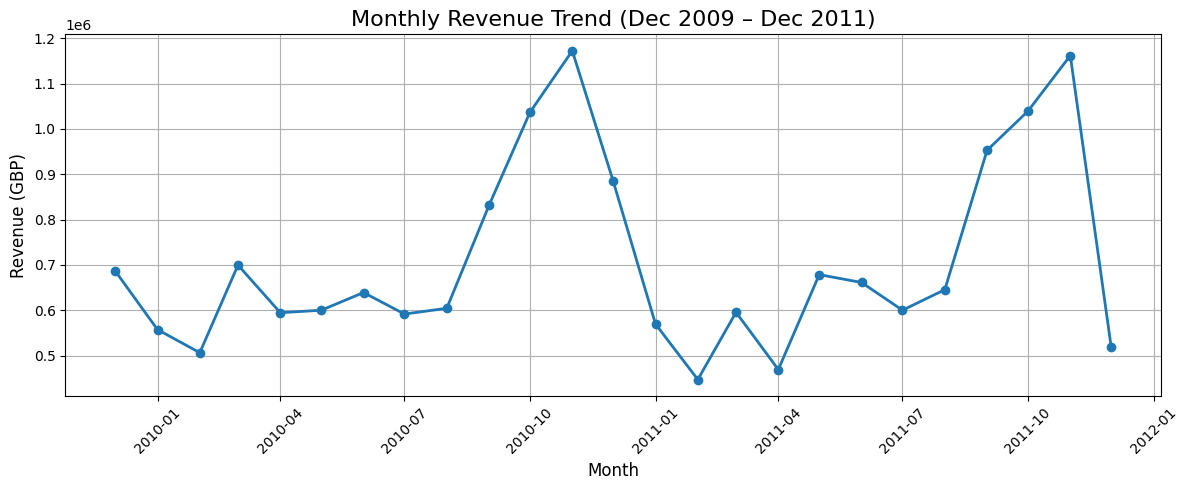

In [82]:
# Visualize Monthly Revenue Trend (2009–2011)

plt.figure(figsize=(12, 5))
plt.plot(monthly_sales_df.index, monthly_sales_df['Total Revenue'], marker='o', linestyle='-', linewidth=2)

# Add title and axis labels
plt.title("Monthly Revenue Trend (Dec 2009 – Dec 2011)", fontsize=16)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Revenue (GBP)", fontsize=12)

# Improve x-axis readability
plt.xticks(rotation=45)
plt.grid(True)

# Final layout adjustments
plt.tight_layout()
plt.show()

## Key Drivers of Sales – Temporal, Geographic & Customer Patterns

In [83]:
# Set global style and color palette
sns.set_theme(style="whitegrid", palette="flare")

#### Time-Based Sales Analysis

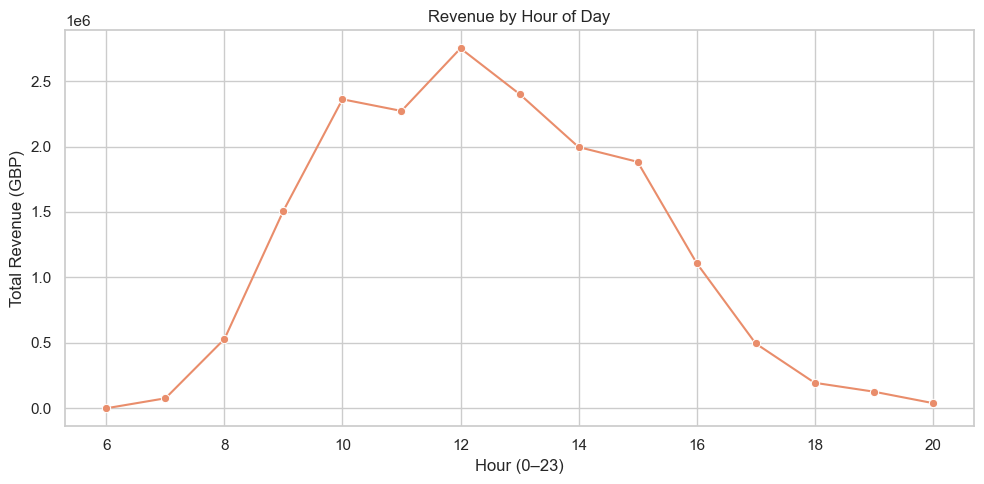

In [84]:
# Extract hour from InvoiceDate index
df['Hour'] = df.index.hour

# Group revenue by hour
revenue_by_hour = df.groupby('Hour')['Revenue'].sum().reset_index()

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=revenue_by_hour, x='Hour', y='Revenue', marker='o')
plt.title('Revenue by Hour of Day')
plt.xlabel('Hour (0–23)')
plt.ylabel('Total Revenue (GBP)')
plt.grid(True)
plt.tight_layout()
plt.show()

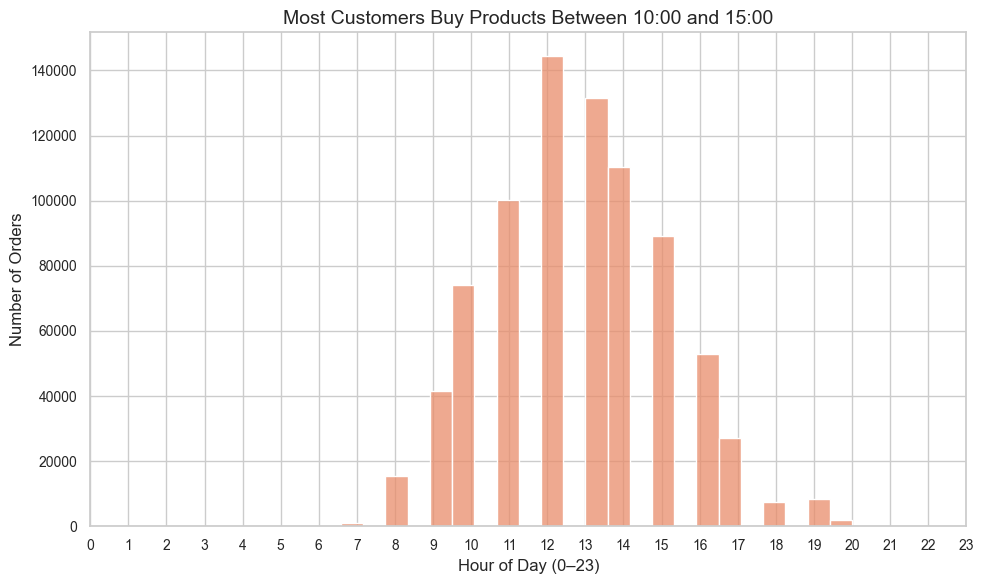

In [85]:
# Plotting the histogram of purchases by hour
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Hour', bins=24, kde=False)

# Customize labels
plt.xlabel('Hour of Day (0–23)', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)
plt.title('Most Customers Buy Products Between 10:00 and 15:00', fontsize=14)
plt.xticks(range(0, 24), fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

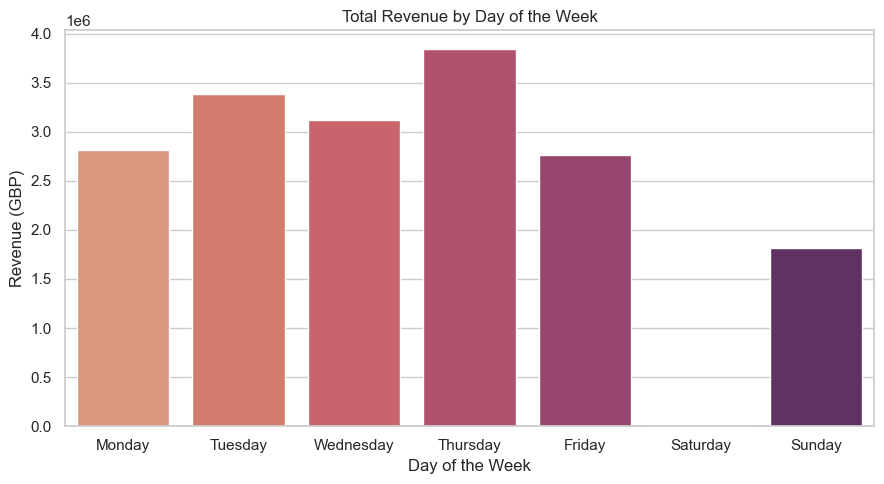

In [86]:
# Extract weekday from InvoiceDate
df['DayOfWeek'] = df.index.day_name()

# Group revenue by weekday
revenue_by_day = df.groupby('DayOfWeek')['Revenue'].sum().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
]).reset_index()

# Plot
plt.figure(figsize=(9, 5))
sns.barplot(data=revenue_by_day, x='DayOfWeek', y='Revenue', palette='flare')
plt.title('Total Revenue by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Revenue (GBP)')
plt.tight_layout()
plt.show()

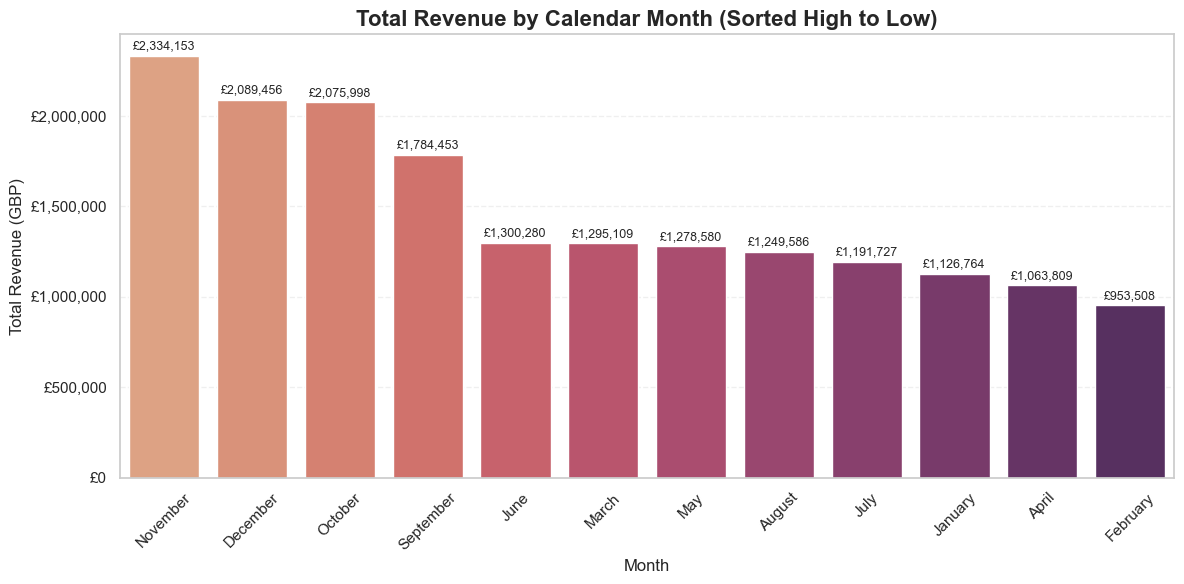

In [87]:
# Group and sort calendar months by total revenue
monthly_sales_df['Month_Name'] = monthly_sales_df.index.month_name()
calendar_months = monthly_sales_df.groupby('Month_Name')['Total Revenue'].sum()
calendar_months_sorted = calendar_months.sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 6))
bars = sns.barplot(x=calendar_months_sorted.index, y=calendar_months_sorted.values, palette='flare')

# Add horizontal value labels above bars
for bar in bars.patches:
    height = bar.get_height()
    bars.annotate(f'£{int(height):,}',
                  (bar.get_x() + bar.get_width() / 2, height + 20000),  # +20000 for spacing above bar
                  ha='center', va='bottom', fontsize=9, rotation=0)

# Chart formatting
plt.title("Total Revenue by Calendar Month (Sorted High to Low)", fontsize=16, fontweight='bold')
plt.xlabel("Month", fontsize=12)
plt.ylabel("Total Revenue (GBP)", fontsize=12)
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'£{int(x):,}'))
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

#### Geographic & Product Insights

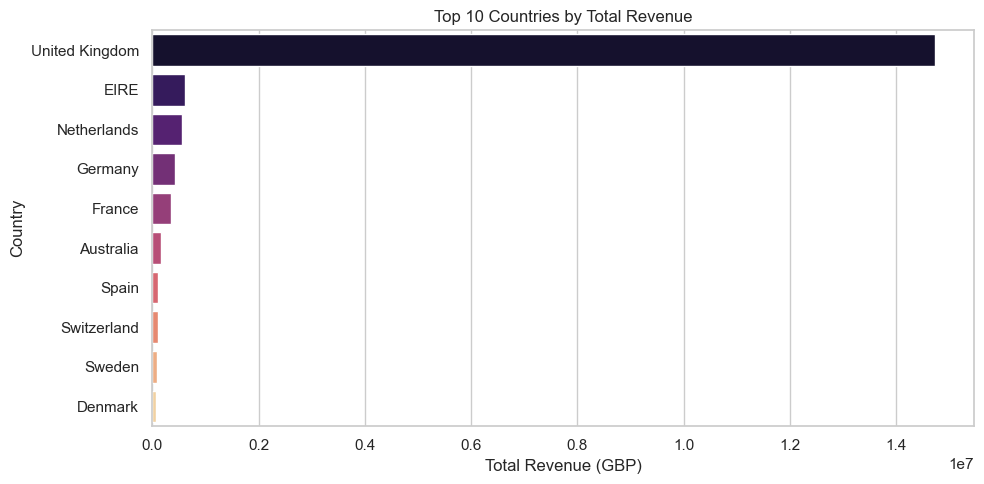

In [88]:
# Top 10 Countries by Revenue

# Group total revenue by country
revenue_by_country = df.groupby('Country')['Revenue'].sum().sort_values(ascending=False).reset_index()

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=revenue_by_country.head(10), x='Revenue', y='Country', palette='magma')
plt.title('Top 10 Countries by Total Revenue')
plt.xlabel('Total Revenue (GBP)')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

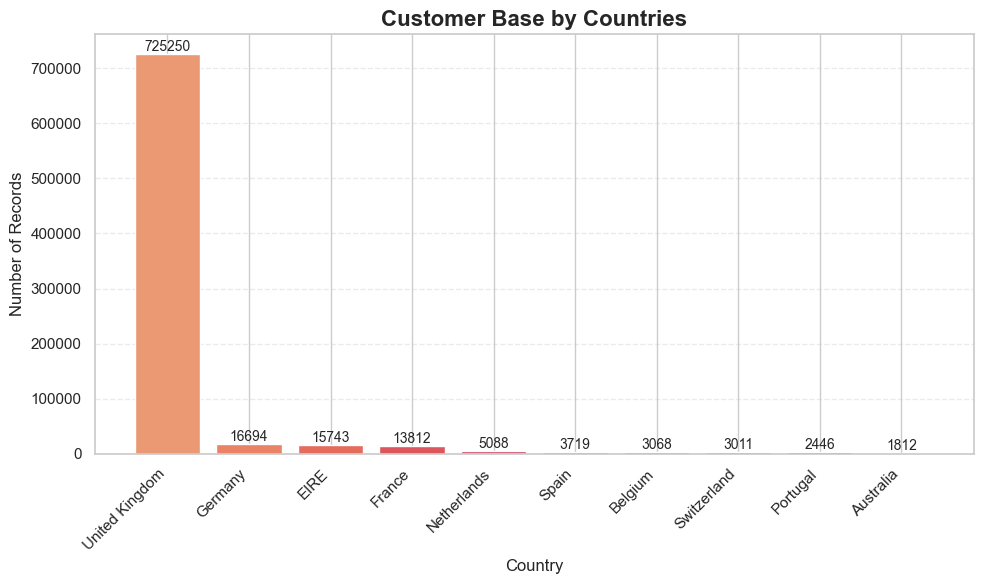

In [89]:
# Top 10 Countries by Number of Records (Customer Base)

# Get the top 10 countries by count of transactions
top_countries = df['Country'].value_counts().head(10)

plt.figure(figsize=(10, 6))
bars = plt.bar(top_countries.index, top_countries.values, color=sns.color_palette("flare", 10))

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 100, f'{int(height)}',
             ha='center', va='bottom', fontsize=10)

plt.title("Customer Base by Countries", fontsize=16, fontweight='bold')
plt.xlabel("Country", fontsize=12)
plt.ylabel("Number of Records", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()

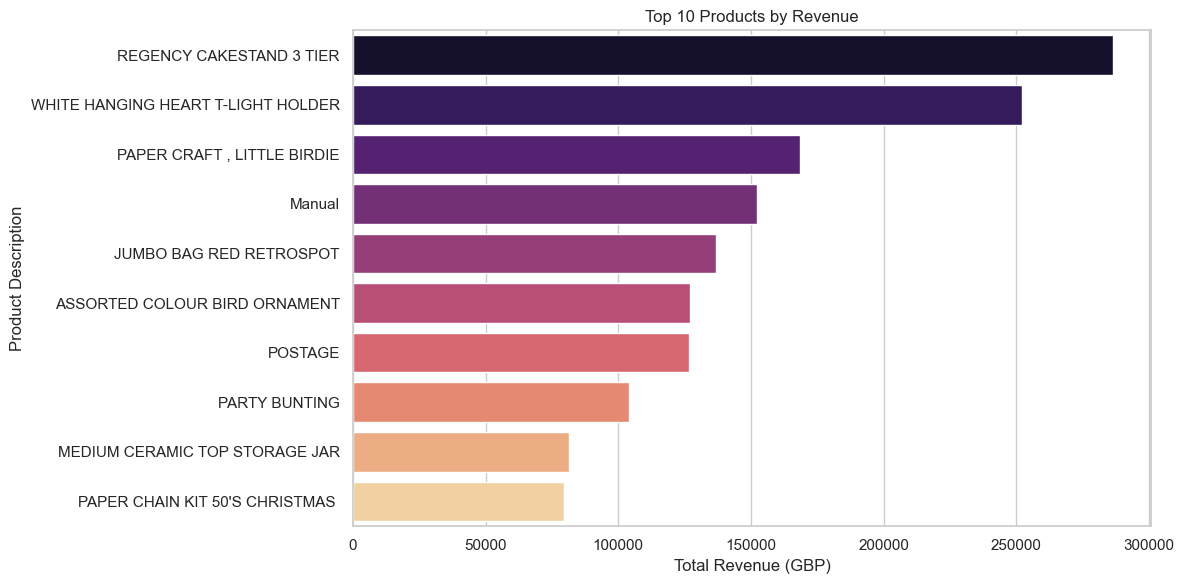

In [90]:
# Top 10 Products by Revenue

# Aggregate revenue by product description
top_products = df.groupby('Description')['Revenue'].sum().sort_values(ascending=False).head(10)

# Bar chart of top 10 products by revenue
plt.figure(figsize=(12, 6))
sns.barplot(x=top_products.values, y=top_products.index, palette='magma')
plt.title('Top 10 Products by Revenue')
plt.xlabel('Total Revenue (GBP)')
plt.ylabel('Product Description')
plt.tight_layout()
plt.show()

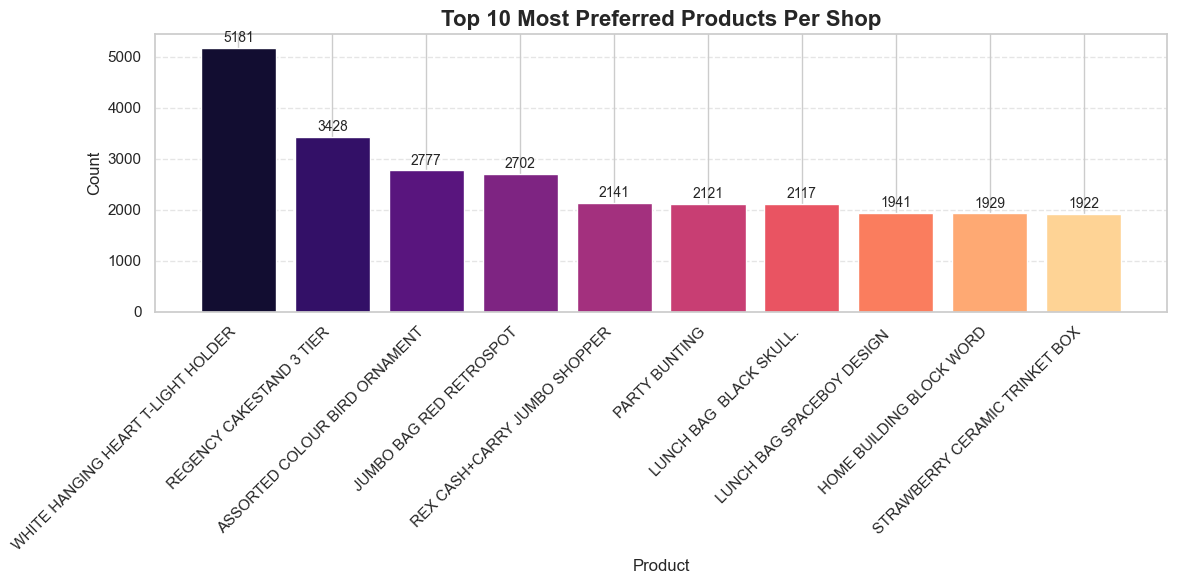

In [91]:
# Top 10 Most Preferred Products by Frequency

# Get the top 10 product descriptions by number of times they appear
most_preferred_products = df['Description'].value_counts().head(10)

plt.figure(figsize=(12, 6))
bars = plt.bar(most_preferred_products.index, most_preferred_products.values, color=sns.color_palette("magma", 10))

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 50, f'{int(height)}',
             ha='center', va='bottom', fontsize=10)

plt.title("Top 10 Most Preferred Products Per Shop", fontsize=16, fontweight='bold')
plt.xlabel("Product", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [92]:
# Check unique countries
print("Unique countries:", df['Country'].nunique())
print("Country distribution:\n", df['Country'].value_counts())

Unique countries: 41
Country distribution:
 Country
United Kingdom          725250
Germany                  16694
EIRE                     15743
France                   13812
Netherlands               5088
Spain                     3719
Belgium                   3068
Switzerland               3011
Portugal                  2446
Australia                 1812
Channel Islands           1569
Italy                     1468
Norway                    1436
Sweden                    1319
Cyprus                    1155
Finland                   1032
Austria                    922
Denmark                    798
Greece                     657
Unspecified                521
Poland                     512
Japan                      485
USA                        409
United Arab Emirates       383
Singapore                  339
Israel                     322
Malta                      282
Iceland                    253
Canada                     228
Lithuania                  189
RSA               

#### Customer Behavior

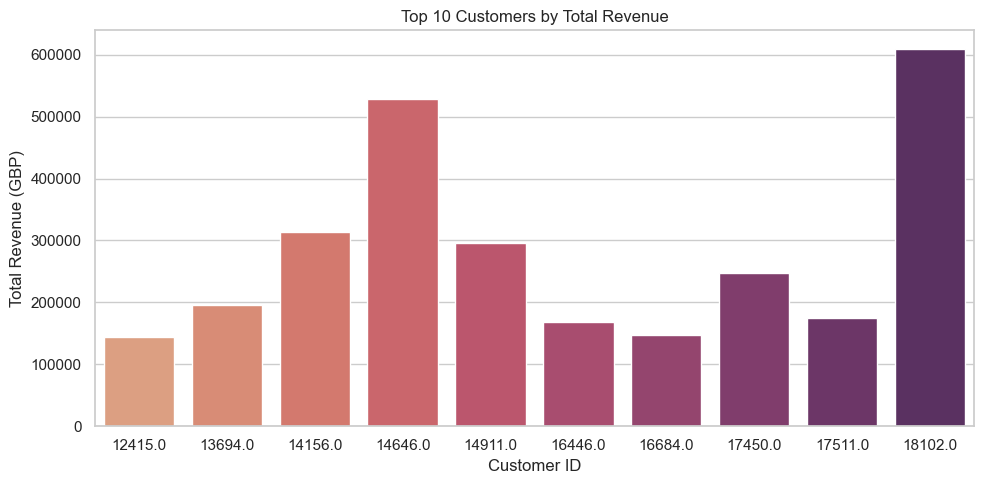

In [93]:
# Compute total revenue per customer
customer_revenue = df.groupby('Customer ID')['Revenue'].sum().sort_values(ascending=False).head(10).reset_index()

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=customer_revenue, x='Customer ID', y='Revenue', palette='flare')
plt.title('Top 10 Customers by Total Revenue')
plt.xlabel('Customer ID')
plt.ylabel('Total Revenue (GBP)')
plt.tight_layout()
plt.show()

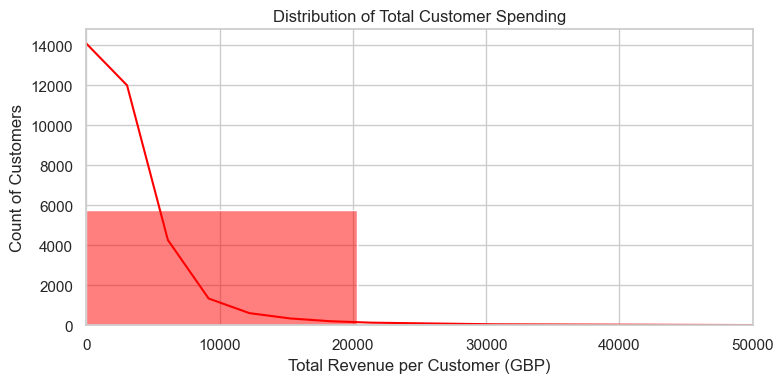

In [94]:
# Distribution of Total Customer Spending

#Compute customer revenue summary
customer_behavior = df.groupby('Customer ID')['Revenue'].agg(['count', 'sum']).reset_index()
customer_behavior.columns = ['Customer ID', 'Purchase Frequency', 'Total Revenue']

# Histogram of customer revenue
plt.figure(figsize=(8, 4))
sns.histplot(customer_behavior['Total Revenue'], bins=30, kde=True, color='red')
plt.title('Distribution of Total Customer Spending')
plt.xlabel('Total Revenue per Customer (GBP)')
plt.ylabel('Count of Customers')

# Limit the x-axis to 200,000
plt.xlim(0, 50000)

plt.tight_layout()
plt.show()

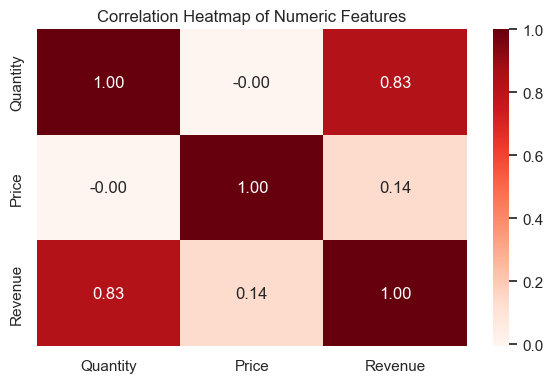

In [95]:
# Select relevant numeric columns
numeric_cols = df[['Quantity', 'Price', 'Revenue']]

# Compute correlation matrix
correlation_matrix = numeric_cols.corr()

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='Reds', fmt='.2f')
plt.title('Correlation Heatmap of Numeric Features')
plt.tight_layout()
plt.show()

## Time Series Preparation

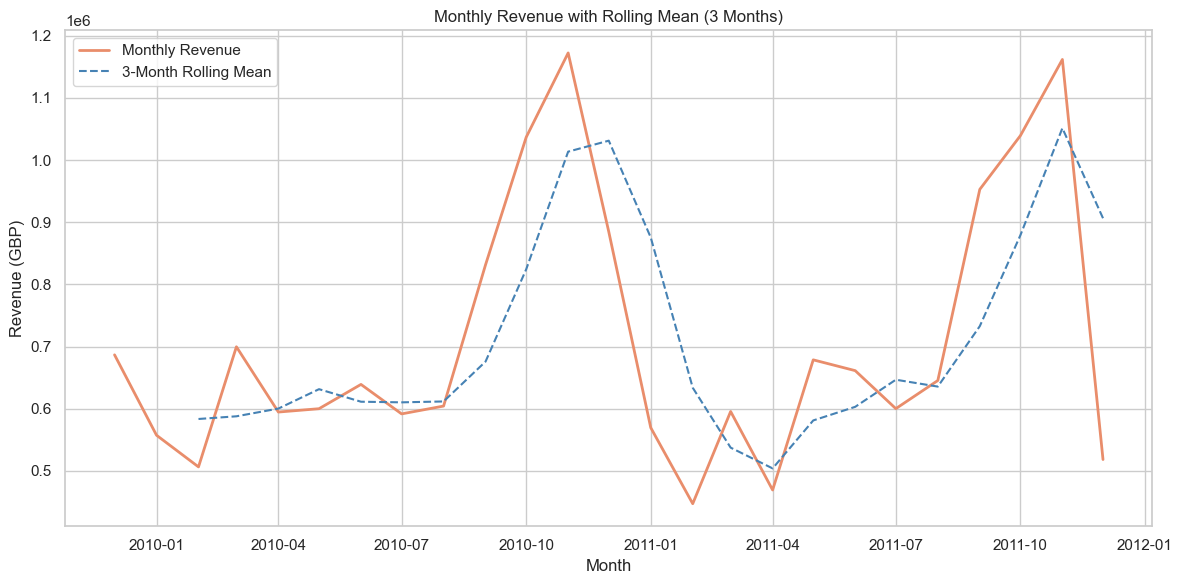

In [96]:
# Plot actual and rolling revenue
monthly_sales_df['Rolling Mean (3M)'] = monthly_sales_df['Total Revenue'].rolling(window=3).mean()

plt.figure(figsize=(12, 6))
plt.plot(monthly_sales_df.index, monthly_sales_df['Total Revenue'], label='Monthly Revenue', linewidth=2)
plt.plot(monthly_sales_df['Rolling Mean (3M)'], label='3-Month Rolling Mean', linestyle='--', color='steelblue')
plt.title("Monthly Revenue with Rolling Mean (3 Months)")
plt.xlabel("Month")
plt.ylabel("Revenue (GBP)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

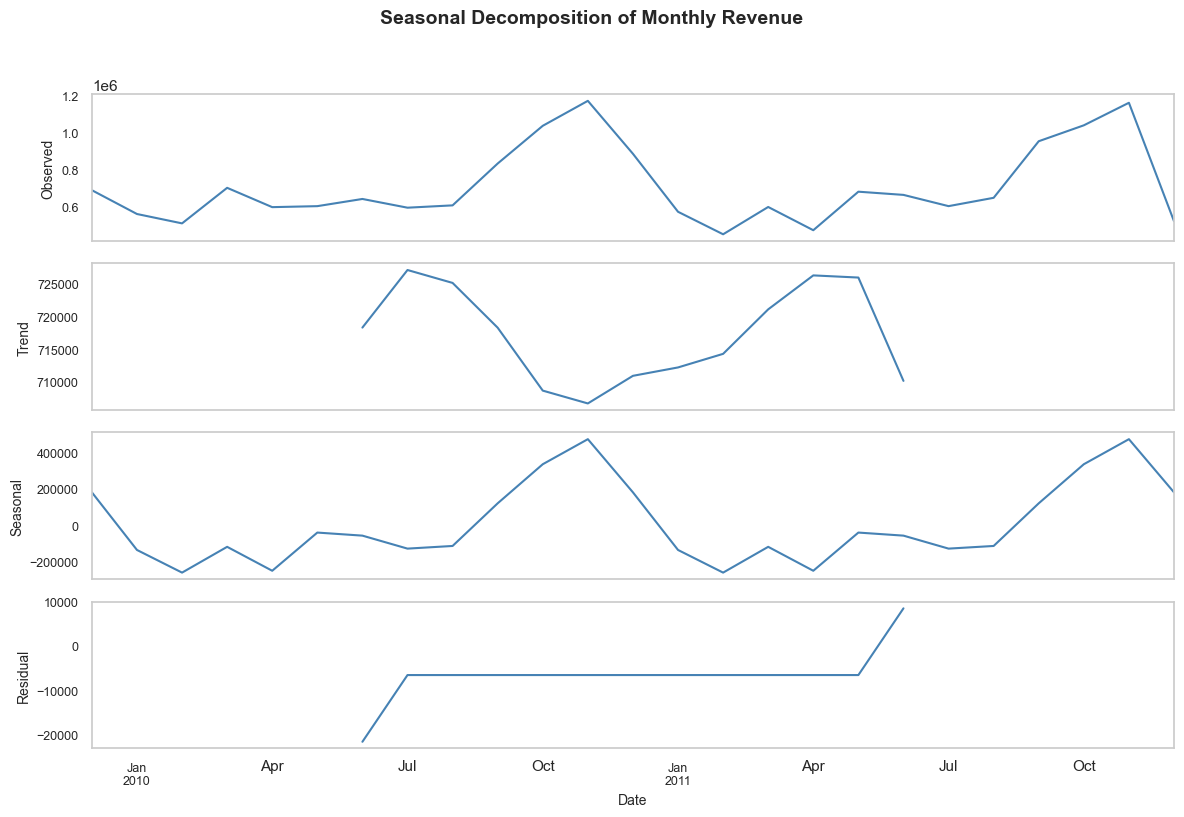

In [97]:
# Input time series
ts = monthly_sales_df['Total Revenue']

# Perform seasonal decomposition (additive model)
decomposition = seasonal_decompose(ts, model='additive', period=12)

# Plot with minimalist, modern style
fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

# Plot components
decomposition.observed.plot(ax=axes[0], legend=False, color='steelblue')
axes[0].set_ylabel('Observed', fontsize=10)

decomposition.trend.plot(ax=axes[1], legend=False, color='steelblue')
axes[1].set_ylabel('Trend', fontsize=10)

decomposition.seasonal.plot(ax=axes[2], legend=False, color='steelblue')
axes[2].set_ylabel('Seasonal', fontsize=10)

decomposition.resid.plot(ax=axes[3], legend=False, color='steelblue')
axes[3].set_ylabel('Residual', fontsize=10)
axes[3].set_xlabel('Date', fontsize=10)

# Apply consistent style
for ax in axes:
    ax.set_facecolor('white')
    ax.tick_params(axis='both', labelsize=9)
    ax.grid(False)

# Title
fig.suptitle('Seasonal Decomposition of Monthly Revenue', fontsize=14, weight='bold', y=1.02)

plt.tight_layout()
plt.show()

In [98]:
# Stationarity Check (ADF Test)

result = adfuller(ts)
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] < 0.05:
    print("Series is likely stationary.")
else:
    print("Series is likely non-stationary. Consider differencing.")

ADF Statistic: -4.249383131742332
p-value: 0.0005429353467698826
Series is likely stationary.


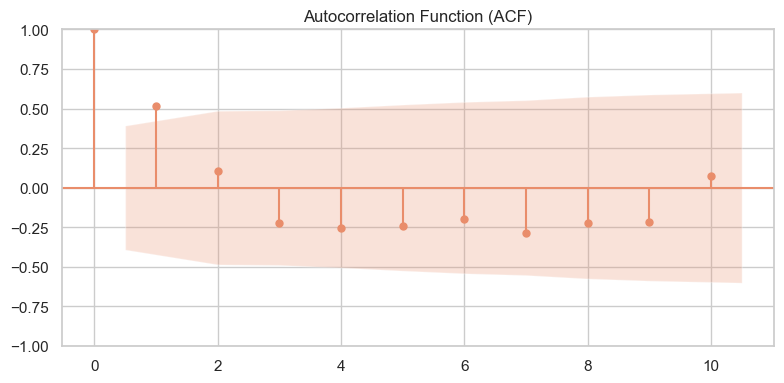

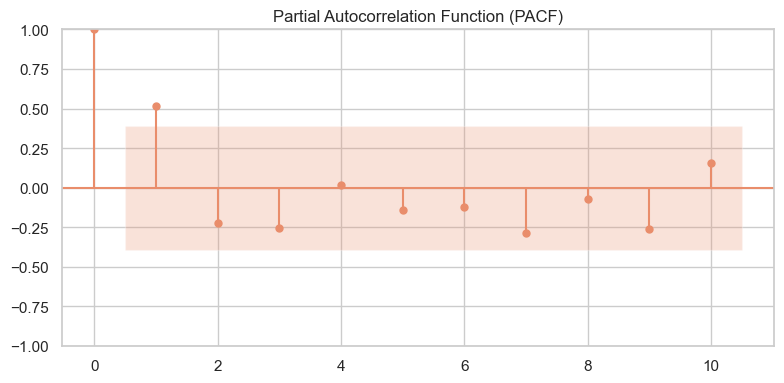

In [99]:
# ACF Plot
plt.figure(figsize=(8, 4))
plot_acf(ts, lags=10, ax=plt.gca(), title='Autocorrelation Function (ACF)')
plt.tight_layout()
plt.show()

# PACF Plot
plt.figure(figsize=(8, 4))
plot_pacf(ts, lags=10, ax=plt.gca(), method='ywm', title='Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()

## Time Series Forecasting

In [100]:
# Extract the series
ts = monthly_sales_df['Total Revenue']

# Train/test split
train_size = int(len(ts) * 0.85)
train, test = ts[:train_size], ts[train_size:]

# === Fit SARIMA ===
sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_fit = sarima_model.fit(disp=False)

# SARIMA Forecast
sarima_forecast = sarima_fit.forecast(steps=len(test))

# Evaluate SARIMA
sarima_rmse = np.sqrt(mean_squared_error(test, sarima_forecast))
print(f'SARIMA Forecast RMSE: £{sarima_rmse:,.2f}')

SARIMA Forecast RMSE: £212,906.15


In [101]:
# === Fit ARIMA ===
arima_model = ARIMA(train, order=(1, 0, 1))
arima_fit = arima_model.fit()

# ARIMA Forecast
arima_forecast = arima_fit.forecast(steps=len(test))

# Evaluate ARIMA
arima_rmse = np.sqrt(mean_squared_error(test, arima_forecast))
print(f'ARIMA Forecast RMSE: £{arima_rmse:,.2f}')

ARIMA Forecast RMSE: £347,997.70


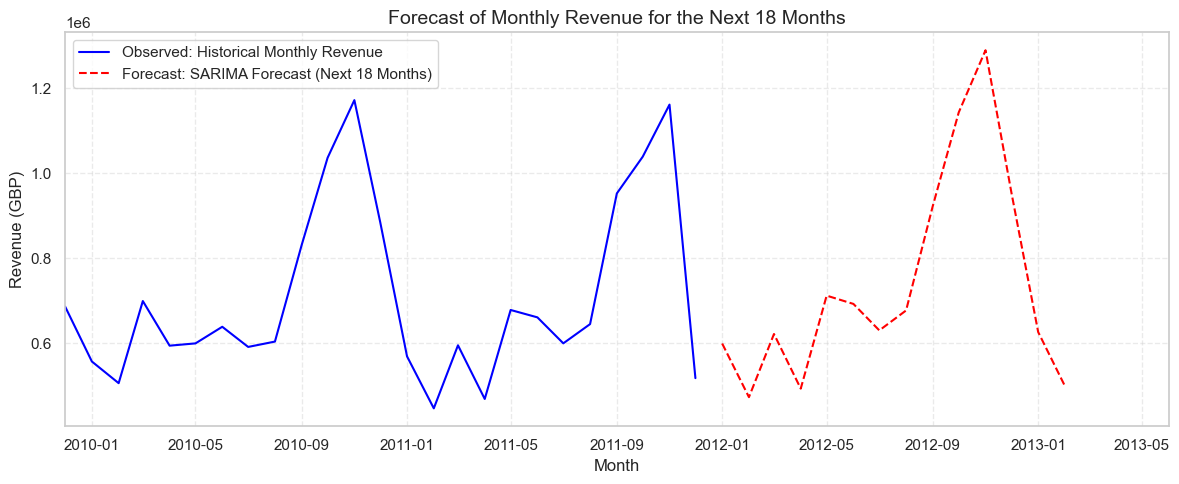

In [102]:
future_steps = 18
future_forecast = sarima_fit.forecast(steps=future_steps)

# Create future index
last_date = ts.index[-1]
future_index = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=future_steps, freq='MS')
future_forecast_series = pd.Series(future_forecast, index=future_index)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(ts, label='Observed: Historical Monthly Revenue', color='blue')
plt.plot(future_forecast_series, label='Forecast: SARIMA Forecast (Next 18 Months)', color='red', linestyle='--')

# Extend x-axis to show future dates
plt.xlim([ts.index[0], future_index[-1]])

plt.title('Forecast of Monthly Revenue for the Next 18 Months', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Revenue (GBP)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

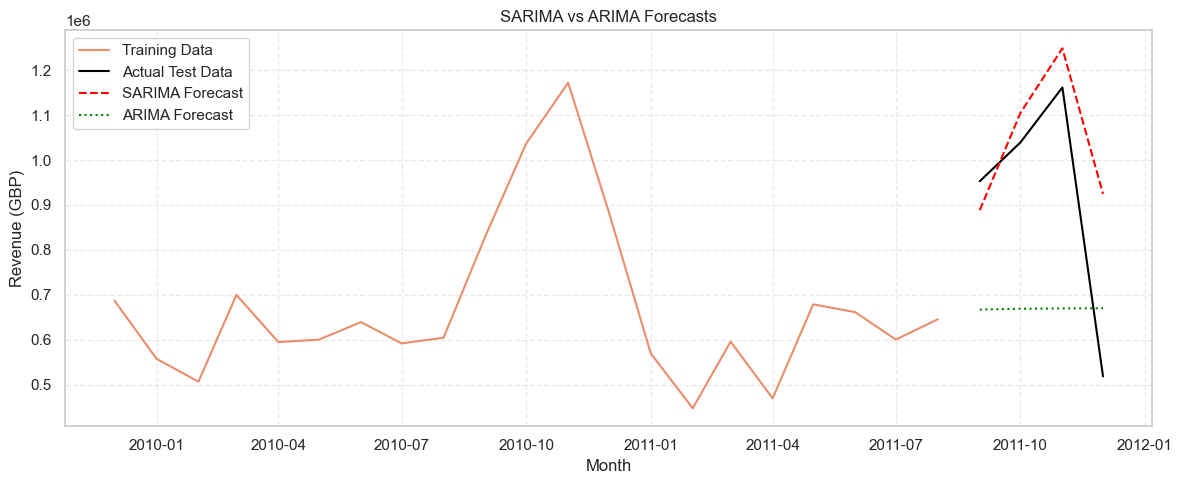

In [103]:
plt.figure(figsize=(12, 5))
plt.plot(train, label='Training Data')
plt.plot(test, label='Actual Test Data', color='black')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', color='red', linestyle='--')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='green', linestyle=':')
plt.title('SARIMA vs ARIMA Forecasts')
plt.xlabel('Month')
plt.ylabel('Revenue (GBP)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

## RFM-Based Customer Clustering

**What is RFM?**

**RFM** stands for **Recency**, **Frequency**, and **Monetary** value, a technique used to segment customers based on their purchasing behavior:

- **Recency**: How recently a customer made a purchase. More recent → more engaged.
- **Frequency**: How often they purchased. Frequent buyers → more loyal.
- **Monetary**: Total amount spent. Higher spenders → more valuable.

RFM helps businesses identify high-value, loyal, or inactive customers for targeted marketing and retention strategies.

In [104]:
# Set snapshot date as one day after the latest transaction in the dataset

snapshot_date = df.index.max() + dt.timedelta(days=1)

# Calculate Recency, Frequency, and Monetary
rfm_df = df.groupby('Customer ID').agg({
    'Revenue': 'sum',                     # Monetary
    'Invoice': 'nunique'                  # Frequency
}).reset_index()

# Recency: days since last purchase
recency_df = df.groupby('Customer ID').apply(lambda x: (snapshot_date - x.index.max()).days).reset_index(name='Recency')

# Merge into RFM table
rfm_df = rfm_df.merge(recency_df, on='Customer ID')
rfm_df.columns = ['Customer ID', 'Monetary', 'Frequency', 'Recency']

In [105]:
# Normalize RFM values for clustering
                     
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df[['Recency', 'Frequency', 'Monetary']])

In [106]:
# Apply KMeans Clustering

kmeans = KMeans(n_clusters=4, random_state=42)
rfm_df['Cluster'] = kmeans.fit_predict(rfm_scaled)

In [107]:
# Map numerical clusters to meaningful labels
cluster_labels = {
    3: "High-Value Loyal Customers",
    2: "Engaged Big Spenders",
    1: "Regular Customers",
    0: "Inactive or Lost Customers"
}


# Add a new column with descriptive names
rfm_df['Cluster Label'] = rfm_df['Cluster'].map(cluster_labels)

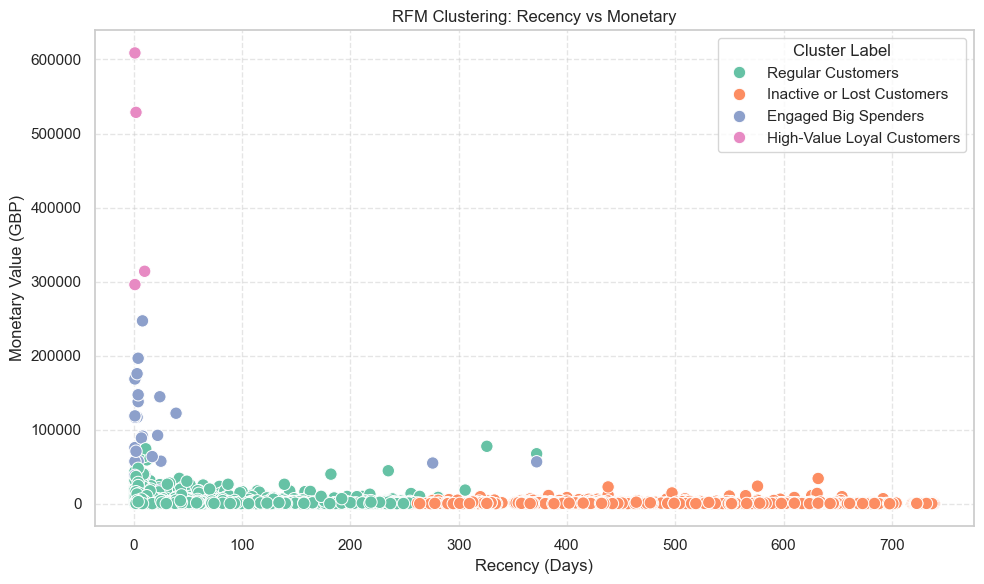

In [108]:
# Scatter Plot with Named Segments
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=rfm_df,
    x='Recency',
    y='Monetary',
    hue='Cluster Label',
    palette='Set2',
    s=80
)

plt.title('RFM Clustering: Recency vs Monetary')
plt.xlabel('Recency (Days)')
plt.ylabel('Monetary Value (GBP)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

We applied KMeans clustering on Recency, Frequency, and Monetary (RFM) values to segment customers into behavioral groups.

**Cluster Summary:**

- **Cluster 3** – High-value loyal: recent, frequent, big spenders
- **Cluster 2** – Regulars: moderate spend and frequency
- **Cluster 1** – At-risk: infrequent, low spend, not recent
- **Cluster 0** – Lost: long inactive, minimal spend


This segmentation helps tailor marketing strategies based on customer behavior.

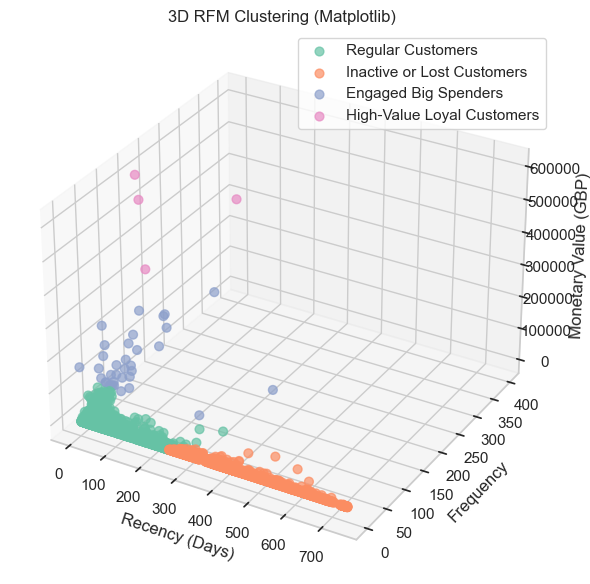

In [109]:
# Set up 3D plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Assign a unique color to each cluster
cluster_labels = rfm_df['Cluster Label'].unique()
colors = plt.cm.Set2(range(len(cluster_labels)))

# Plot each cluster separately
for label, color in zip(cluster_labels, colors):
    cluster_data = rfm_df[rfm_df['Cluster Label'] == label]
    ax.scatter(
        cluster_data['Recency'],
        cluster_data['Frequency'],
        cluster_data['Monetary'],
        label=label,
        s=40,
        alpha=0.7,
        color=color
    )

# Axis labels
ax.set_xlabel('Recency (Days)')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary Value (GBP)')
ax.set_title('3D RFM Clustering (Matplotlib)')
ax.legend()
plt.tight_layout()
plt.show()

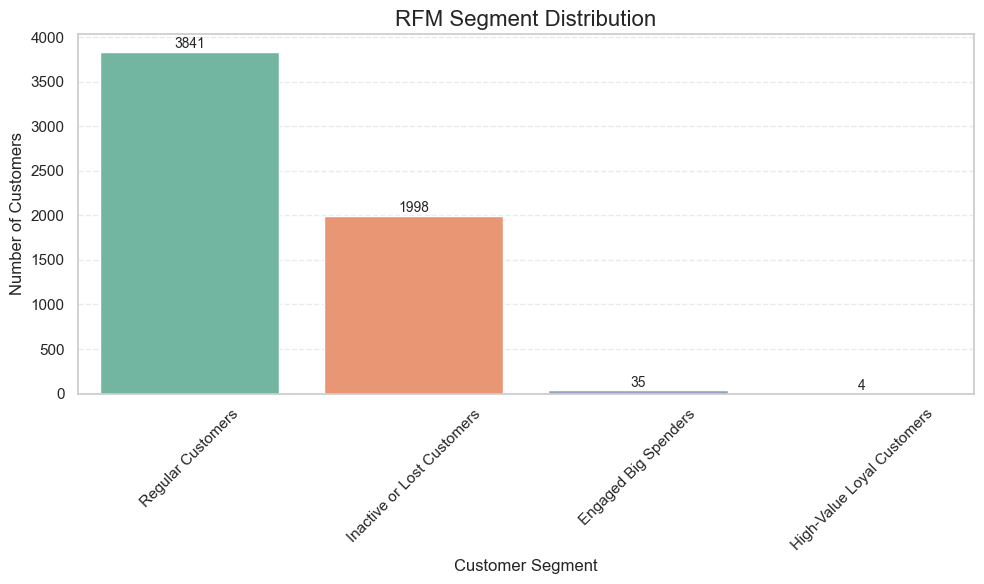

In [110]:
# Count of customers per labeled RFM cluster
segments = rfm_df['Cluster Label'].value_counts()

# Create bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=segments.index, y=segments.values, palette='Set2')

# Annotate values on bars
for i, v in enumerate(segments.values):
    plt.text(i, v + 5, str(v), ha='center', va='bottom', fontsize=10)

# Customize plot
plt.title("RFM Segment Distribution", fontsize=16)
plt.xlabel("Customer Segment", fontsize=12)
plt.ylabel("Number of Customers", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()

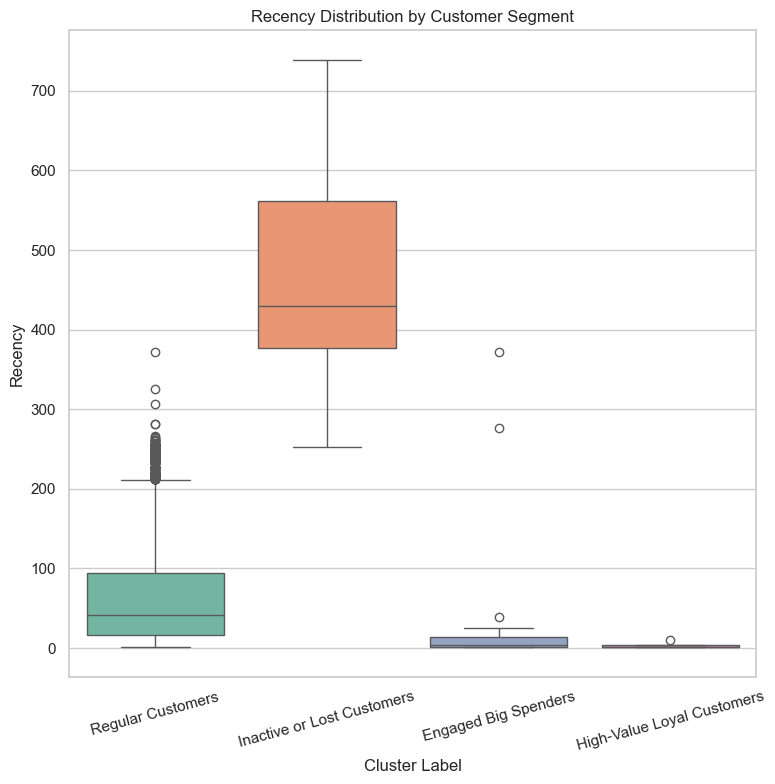

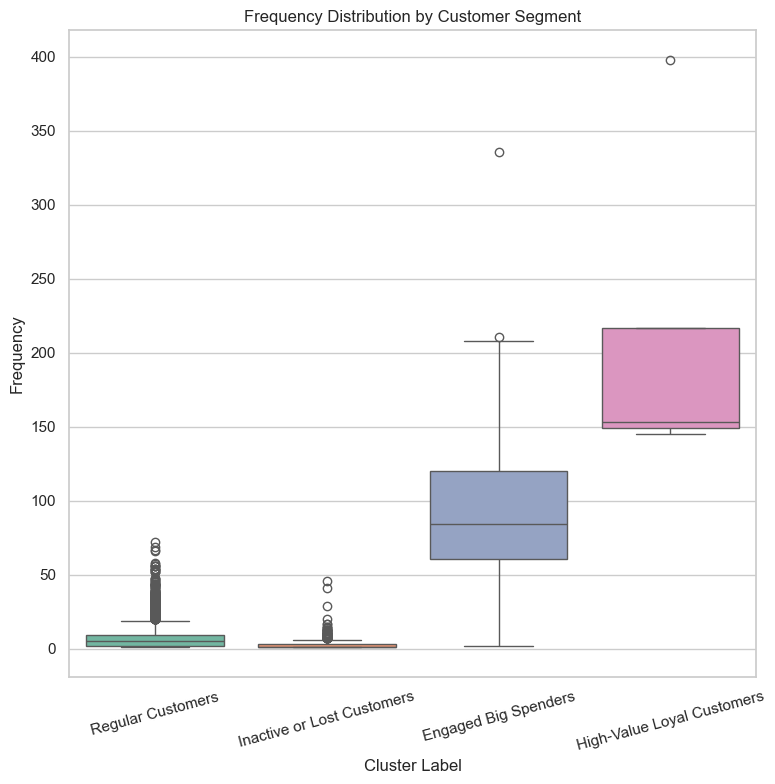

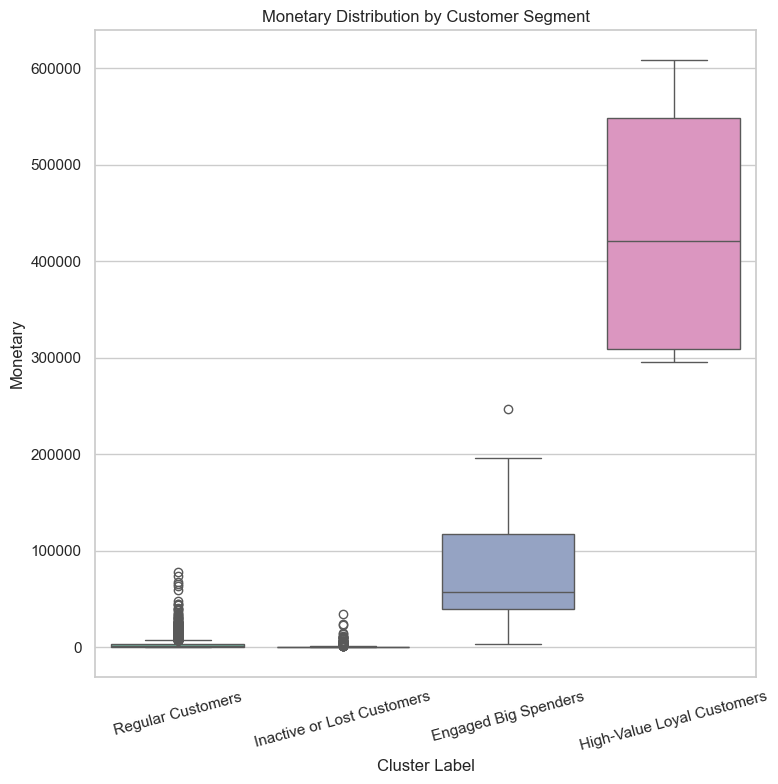

In [111]:
# Recency Boxplot
plt.figure(figsize=(8, 8))
sns.boxplot(data=rfm_df, x='Cluster Label', y='Recency', palette='Set2')
plt.title('Recency Distribution by Customer Segment')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Frequency Boxplot
plt.figure(figsize=(8, 8))
sns.boxplot(data=rfm_df, x='Cluster Label', y='Frequency', palette='Set2')
plt.title('Frequency Distribution by Customer Segment')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Monetary Boxplot
plt.figure(figsize=(8, 8))
sns.boxplot(data=rfm_df, x='Cluster Label', y='Monetary', palette='Set2')
plt.title('Monetary Distribution by Customer Segment')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

In [4]:
# Export RFM clustered data to CSV

# Uncomment the line below if you need to export the rfm segments dataset for Power BI dashboard use.
# rfm_df.to_csv('rfm_segments.csv', index=False)